In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
from tqdm import tqdm

seed = 42
rng = RandomState(seed)

In [2]:
df = pd.read_csv("Model.csv")
df.head()

,Unnamed: 0,destination_Home,destination_No Urgent Place,destination_Work,passanger_Alone,passanger_Friend(s),passanger_Kid(s),passanger_Partner,weather_Rainy,weather_Snowy,...,income,education,age,time,expiration,driving_distance,gender,has_children,direction_opp,Y
0,0,0,1,0,1,0,0,0,0,0,...,3,2,1,1,1,0,0,1,1,1
1,1,0,1,0,0,1,0,0,0,0,...,3,2,1,0,0,0,0,1,1,0
2,2,0,1,0,0,1,0,0,0,0,...,3,2,1,0,0,1,0,1,1,1
3,3,0,1,0,0,1,0,0,0,0,...,3,2,1,1,0,1,0,1,1,0
4,4,0,1,0,0,1,0,0,0,0,...,3,2,1,1,1,1,0,1,1,0


In [3]:
X, y = df.iloc[:, 1:-1], df.iloc[:, -1]
print(X.shape, y.shape)

(12529, 59) (12529,)


In [4]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=seed)
print('Train set: ', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set:  (10023, 59) (10023,)
Test set:  (2506, 59) (2506,)


In [5]:
# Train decision tree, random forest & SVM with their best params
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, 
                            random_state=rng)
rf = RandomForestClassifier(criterion='entropy', n_estimators=100, 
                            random_state=rng)
sv = SVC(kernel='rbf', C=15.0)

dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
sv.fit(X_train, y_train)

SVC(C=15.0)

In [6]:
dt_pred = dt.predict(X_test)
rf_pred = rf.predict(X_test)
sv_pred = sv.predict(X_test)

In [7]:
from sklearn.metrics import accuracy_score, roc_auc_score, plot_confusion_matrix

dt_acc = accuracy_score(y_test, dt_pred)
rf_acc = accuracy_score(y_test, rf_pred)
sv_acc = accuracy_score(y_test, sv_pred)

dt_auc = roc_auc_score(y_test, dt_pred)
rf_auc = roc_auc_score(y_test, rf_pred)
sv_auc = roc_auc_score(y_test, sv_pred)

print('Decision tree acc: %.6f' % dt_acc)
print('Random forest acc: %.6f' % rf_acc)
print('SVM acc: %.6f' % sv_acc)
print()
print('Decision tree AUC: %.6f' % dt_auc)
print('Random forest AUC: %.6f' % rf_auc)
print('SVM AUC: %.6f' % sv_auc)

Decision tree acc: 0.688747
Random forest acc: 0.754589
SVM acc: 0.752993

Decision tree AUC: 0.666410
Random forest AUC: 0.745442
SVM AUC: 0.744329


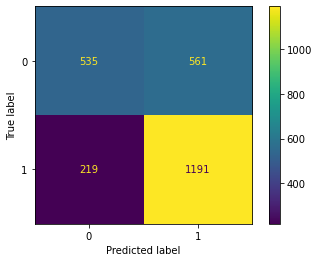

In [8]:
plot_confusion_matrix(dt, X_test, y_test)

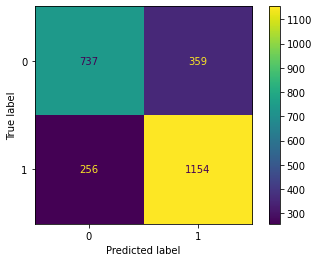

In [9]:
plot_confusion_matrix(rf, X_test, y_test)

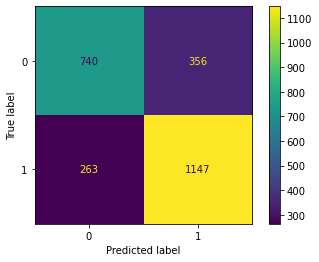

In [10]:
plot_confusion_matrix(sv, X_test, y_test)

In [11]:
coupon_type = ['Bar', 'Carry out & Take away', 'Coffee House', 
               'Restaurant(<20)', 'Restaurant(20-50)']
datasets = {}
for type_name in coupon_type:
    column_name = 'coupon_' + type_name
    data = df[df[column_name] == 1].copy()
    X, y = data.iloc[:, :-1], data.iloc[:, -1]
    
    X = X.drop(columns=['coupon_'+type_name for type_name in coupon_type])
    
    datasets[type_name] = (X, y)

In [12]:
# Cross validation on different type of coupon
# to compare with Bayesian rule sets
# from paper: https://jmlr.org/papers/v18/16-003.html

from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

estimators = [
    DecisionTreeClassifier(criterion='entropy', max_depth=5, 
                           random_state=rng),
    RandomForestClassifier(criterion='entropy', n_estimators=100,
                           random_state=rng),
    SVC(kernel='rbf', C=15.0)
]

for name, estimator in zip(['DT', 'RF', 'SVM'], estimators):
    print('---', name, '---')
    for coupon_type in datasets:
        X, y = datasets[coupon_type]
        scores = cross_val_score(
            estimator, X, y, cv=5, n_jobs=-1, scoring='roc_auc'
        )
        mean = scores.mean()
        std = scores.std()
        print('%-25s: %.3f(%.3f)' % (coupon_type, mean, std))

--- DT ---
Bar                      : 0.654(0.080)
Carry out & Take away    : 0.562(0.059)
Coffee House             : 0.605(0.098)
Restaurant(<20)          : 0.283(0.227)
Restaurant(20-50)        : 0.527(0.038)
--- RF ---
Bar                      : 0.698(0.056)
Carry out & Take away    : 0.612(0.061)
Coffee House             : 0.659(0.084)
Restaurant(<20)          : 0.379(0.260)
Restaurant(20-50)        : 0.541(0.070)
--- SVM ---
Bar                      : 0.568(0.145)
Carry out & Take away    : 0.530(0.090)
Coffee House             : 0.572(0.153)
Restaurant(<20)          : 0.256(0.231)
Restaurant(20-50)        : 0.504(0.137)
